<a href="https://colab.research.google.com/github/pixelwizard2/Project.AI--ColorQuest---AI-s-Journey-in-Reviving-WWII-Imagery/blob/main/ColorQuest_code_(%ED%95%9C%EA%B5%AD%EC%96%B4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Google Drive 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. 데이터 파일 불러오기(확인용)

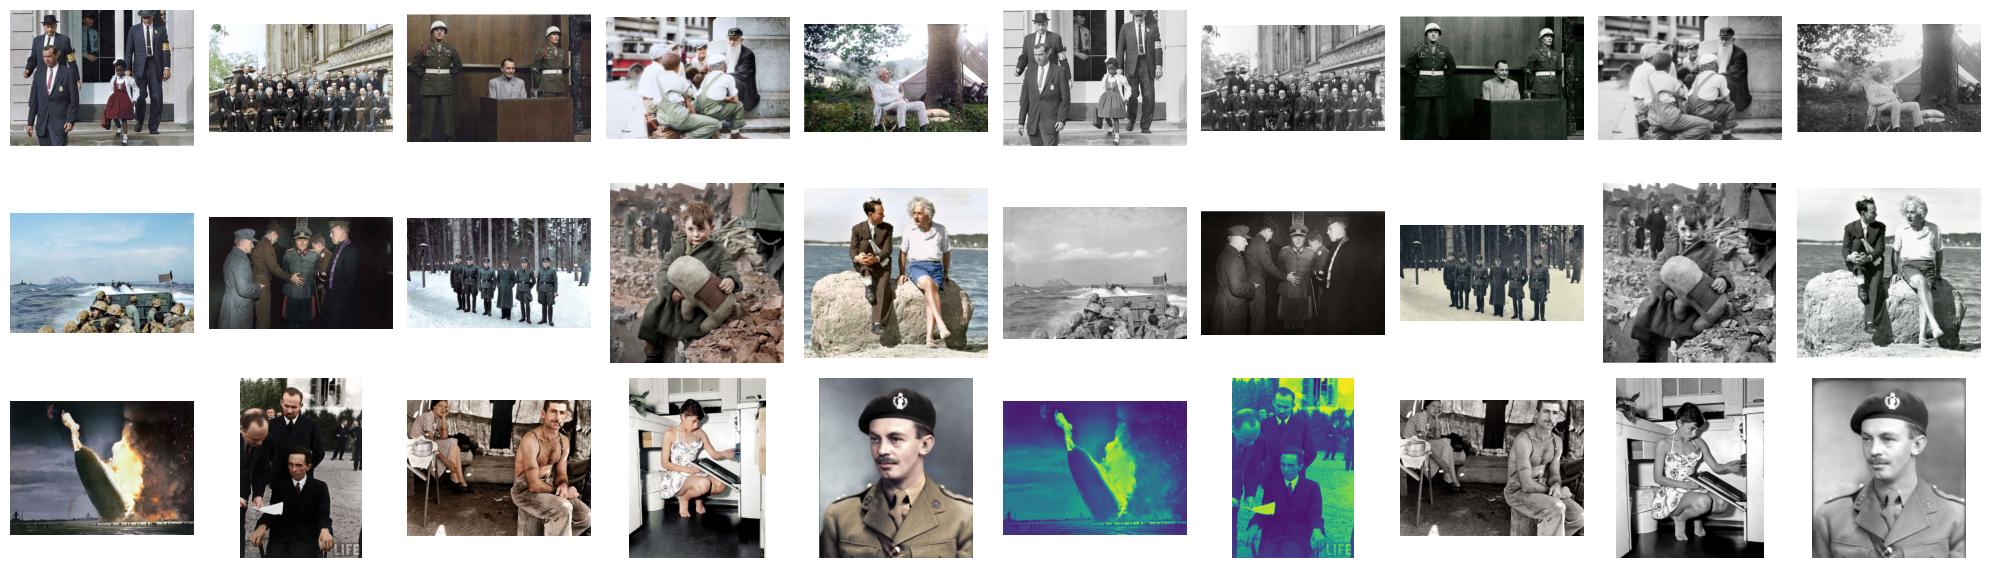

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 두 폴더 경로
folder_path1 = '/content/drive/My Drive/image_dataset(1)/color_images'
folder_path2 = '/content/drive/My Drive/image_dataset(1)/gray_images'

# 이미지 파일 목록
image_files1 = [os.path.join(folder_path1, f) for f in os.listdir(folder_path1) if os.path.isfile(os.path.join(folder_path1, f))]
image_files2 = [os.path.join(folder_path2, f) for f in os.listdir(folder_path2) if os.path.isfile(os.path.join(folder_path2, f))]

# 이미지 표시를 위한 준비
fig, axes = plt.subplots(3, 10, figsize=(20, 6))  # 3행 10열의 서브플롯 생성

# 왼쪽에 폴더1의 이미지들을 벌집 모양으로 배열
for i, file in enumerate(image_files1):
    img = mpimg.imread(file)
    ax = axes[i // 5, i % 5]  # 3행 5열에 이미지를 배치
    ax.imshow(img)
    ax.axis('off')

# 오른쪽에 폴더2의 이미지들을 벌집 모양으로 배열
for i, file in enumerate(image_files2):
    img = mpimg.imread(file)
    ax = axes[i // 5, i % 5 + 5]  # 3행 5열에 이미지를 배치 (5를 더하여 오른쪽에 배치)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

3. 이미지 불러오기 및 전처리

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Input, concatenate, Dropout, BatchNormalization

# 데이터 불러오기 및 전처리
def load_images(folder_path, color_mode, image_size=(256, 256)):
    images = []
    for filename in os.listdir(folder_path):
        if color_mode == 'color':
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            img = np.expand_dims(img, axis=-1)
        img = cv2.resize(img, image_size)
        img = img / 255.0
        images.append(img)
    return np.stack(images)

# 이미지 폴더 경로
folder_path1 = '/content/drive/My Drive/image_dataset(1)/color_images'
folder_path2 = '/content/drive/My Drive/image_dataset(1)/gray_images'

color_images = load_images(folder_path1, color_mode='color')
gray_images = load_images(folder_path2, color_mode='gray')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(gray_images, color_images, test_size=0.1, random_state=42)

# 모델 생성 시 입력 형태 설정
input_shape = (256, 256, 1)  # 흑백 이미지의 경우 (256, 256, 1)

4. 딥러닝 모델 설계(4가지) 및 구축

In [ ]:
# 다양한 딥러닝 모델 설계 및 구축
def build_simple_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model


def build_deep_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))     # 업샘플링을 한 번만 적용합니다.
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model




def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, x)
    return autoencoder


def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = Dropout(0.5)(conv3)

    # Decoding path
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Dropout(0.5)(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.25)(conv5)

    # Output layer
    conv6 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv5)

    unet = Model(inputs=[inputs], outputs=[conv6])
    return unet

5. 모델 생성 및 컴파일


In [ ]:
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 모델 이름과 해당하는 함수를 사전에 매핑
model_builders = {
    'simple_cnn': build_simple_cnn,
    'deep_cnn': build_deep_cnn,
    'autoencoder': build_autoencoder,
    'unet': build_unet,
}

# X_train과 X_test에 채널 차원 추가
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)

# 입력 형태를 정의
input_shape = X_train.shape[1:]

# 모든 모델을 생성하고 컴파일
models = {}
for name, builder in model_builders.items():
    print(f"Building and compiling the {name} model...")
    model = builder(input_shape)
    model.compile(optimizer='adam', loss='mean_squared_error')
    models[name] = model
    model.summary()  # 모델 요약 출력

Building and compiling the simple_cnn model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 conv2d_90 (Conv2D)          (None, 256, 256, 3)       867       
                                                                 
Total params: 1187 (4.64 KB)
Trainable params: 1187 (4.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Building and compiling the deep_cnn model...
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 12

6. 모델 학습 및 성능 평가

Training simple_cnn...
Epoch 1/10
11/11 [==============================] - 2s 102ms/step - loss: 0.0826 - val_loss: 0.1001
Epoch 2/10
11/11 [==============================] - 1s 94ms/step - loss: 0.0766 - val_loss: 0.0956
Epoch 3/10
11/11 [==============================] - 1s 94ms/step - loss: 0.0732 - val_loss: 0.0894
Epoch 4/10
11/11 [==============================] - 1s 95ms/step - loss: 0.0687 - val_loss: 0.0820
Epoch 5/10
11/11 [==============================] - 1s 95ms/step - loss: 0.0634 - val_loss: 0.0743
Epoch 6/10
11/11 [==============================] - 1s 97ms/step - loss: 0.0579 - val_loss: 0.0643
Epoch 7/10
11/11 [==============================] - 1s 96ms/step - loss: 0.0517 - val_loss: 0.0544
Epoch 8/10
11/11 [==============================] - 1s 93ms/step - loss: 0.0466 - val_loss: 0.0467
Epoch 9/10
11/11 [==============================] - 1s 94ms/step - loss: 0.0425 - val_loss: 0.0359
Epoch 10/10
11/11 [==============================] - 1s 135ms/step - loss: 0.0346 - v

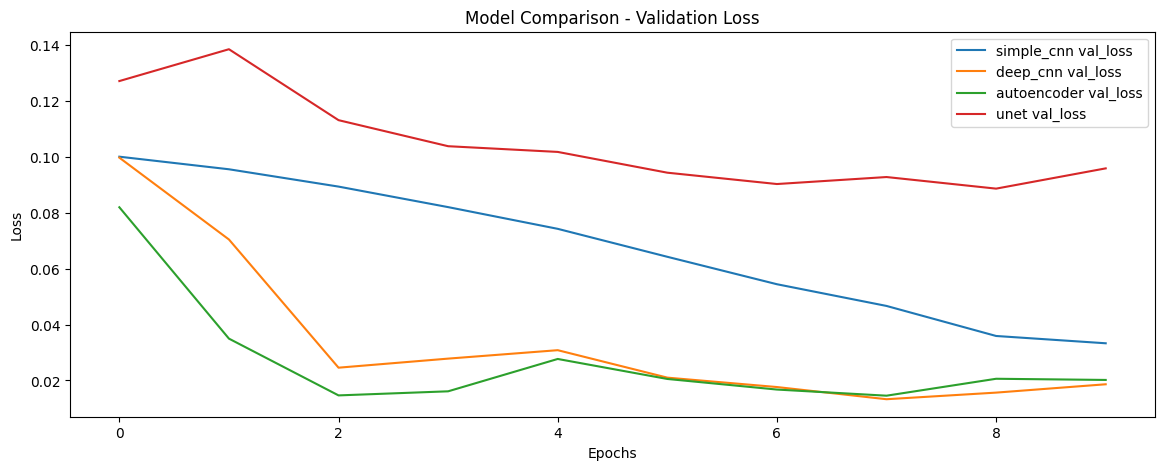

In [ ]:
# 모델 학습 및 성능 평가
history_dict = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_split=0.1)
    history_dict[name] = history
    model.save(f"{name}_model.h5")

# 모델별 성능 비교를 위한 손실 그래프
plt.figure(figsize=(14, 5))
for name, history in history_dict.items():
    val_loss = history.history['val_loss']
    plt.plot(val_loss, label=f'{name} val_loss')

plt.title('Model Comparison - Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7. 모델 다운로드

In [1]:
from google.colab import files

# 모든 모델을 순회하면서 각각을 다운로드합니다.
for name in models.keys():
    file_name = f"{name}_model.h5"
    # 구글 드라이브에서 다운로드 링크를 생성합니다.
    files.download(file_name)

NameError: name 'models' is not defined

In [ ]:
# 저장된 모델 파일을 구글 드라이브로 이동시킵니다.
for name in models.keys():
    file_name = f"{name}_model.h5"
    destination_path = f"/content/drive/My Drive/{file_name}"
    !cp {file_name} {destination_path}  # 파일을 구글 드라이브로 복사합니다.

cp: target 'Drive/simple_cnn_model.h5' is not a directory
cp: target 'Drive/deep_cnn_model.h5' is not a directory
cp: target 'Drive/autoencoder_model.h5' is not a directory
cp: target 'Drive/unet_model.h5' is not a directory


8. 모델 업로드

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model
import numpy as np
import cv2

# 불러올 모델들의 목록입니다.
model_names = ['simple_cnn', 'deep_cnn', 'autoencoder', 'unet']

# 각 모델을 불러옵니다.
loaded_models = {}
for name in model_names:
    file_path = f"/content/drive/MyDrive/{name}_model.h5"
    loaded_models[name] = load_model(file_path)

for name, model in loaded_models.items():   # 모델이 정상적으로 불러와졌는지 확인하는 코드
    print(f"{name} model is loaded.")

Mounted at /content/drive
simple_cnn model is loaded.
deep_cnn model is loaded.
autoencoder model is loaded.
unet model is loaded.


9. 모델 구동(흑백사진 변환)

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_process_image(file_path, color_mode='rgb', image_size=(256, 256)):
    # 이미지를 불러옵니다.
    img = load_img(file_path, color_mode=color_mode, target_size=image_size)
    # 이미지를 numpy 배열로 변환합니다.
    img = img_to_array(img)
    # 정규화를 위해 255로 나눕니다.
    img = img / 255.0
    return img

# 테스트 이미지 경로
test_image_paths = ['/content/drive/MyDrive/test_photo_before1.jpg',
                    '/content/drive/MyDrive/test_photo_before2.jpg']

for path in test_image_paths:
    # 이미지를 불러오고 처리합니다.
    test_image = load_and_process_image(path, color_mode='grayscale')
    test_image = np.expand_dims(test_image, axis=0)  # 배치 차원을 추가합니다.

    for name, model in loaded_models.items():
        predicted = model.predict(test_image)
        predicted = np.squeeze(predicted) * 255.0  # 배치 차원을 제거하고 재조정합니다.
        output_path = path.replace('before', f'after_{name}')
        cv2.imwrite(output_path, cv2.cvtColor(predicted.astype(np.uint8), cv2.COLOR_RGB2BGR))
        print(f"Output saved to {output_path}")

print("All models have been trained and evaluated.")

1/1 [==============================] - 1s 889ms/step
Output saved to /content/drive/MyDrive/test_photo_after_simple_cnn1.jpg
1/1 [==============================] - 2s 2s/step
Output saved to /content/drive/MyDrive/test_photo_after_deep_cnn1.jpg
1/1 [==============================] - 0s 350ms/step
Output saved to /content/drive/MyDrive/test_photo_after_autoencoder1.jpg
1/1 [==============================] - 1s 1s/step
Output saved to /content/drive/MyDrive/test_photo_after_unet1.jpg
1/1 [==============================] - 0s 37ms/step
Output saved to /content/drive/MyDrive/test_photo_after_simple_cnn2.jpg
1/1 [==============================] - 1s 990ms/step
Output saved to /content/drive/MyDrive/test_photo_after_deep_cnn2.jpg
1/1 [==============================] - 0s 288ms/step
Output saved to /content/drive/MyDrive/test_photo_after_autoencoder2.jpg
1/1 [==============================] - 1s 990ms/step
Output saved to /content/drive/MyDrive/test_photo_after_unet2.jpg
All models have been 

10. 모델 구현(컬러사진 출력)

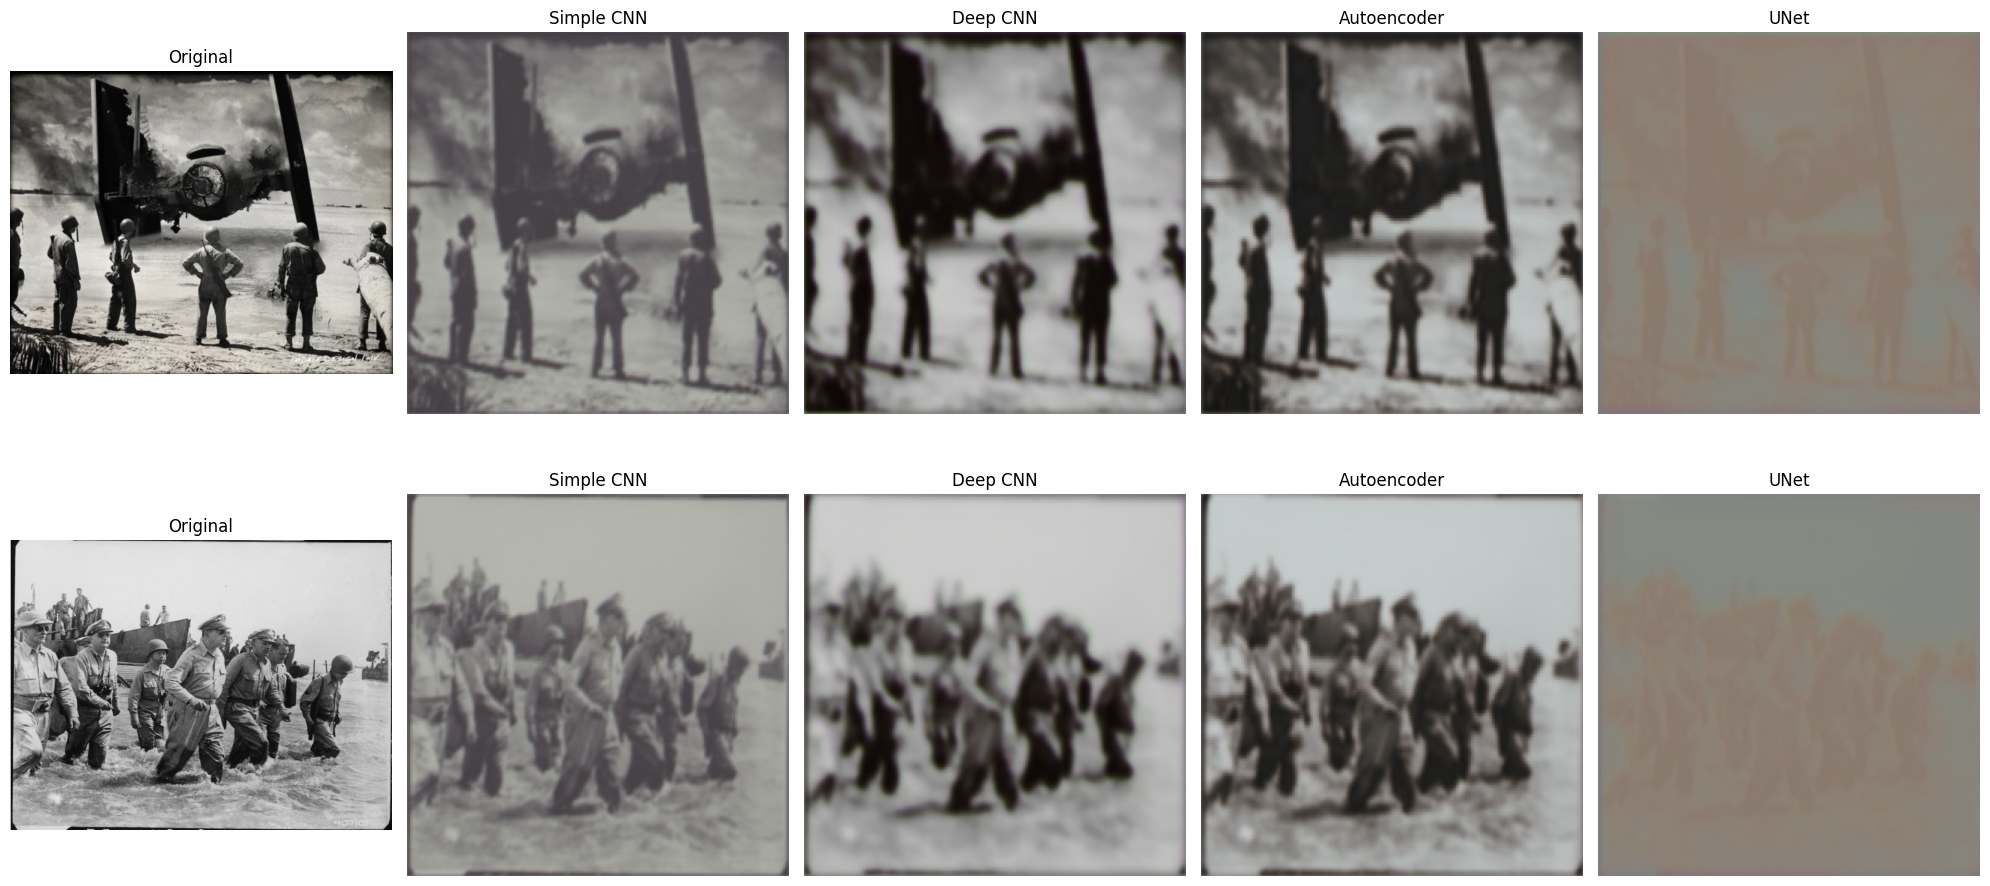

In [6]:
import matplotlib.pyplot as plt
import cv2

# 결과 이미지 경로
result_paths = [
    '/content/drive/MyDrive/test_photo_before1.jpg', # 원본 이미지 1
    '/content/drive/MyDrive/test_photo_after_simple_cnn1.jpg',
    '/content/drive/MyDrive/test_photo_after_deep_cnn1.jpg',
    '/content/drive/MyDrive/test_photo_after_autoencoder1.jpg',
    '/content/drive/MyDrive/test_photo_after_unet1.jpg',
    '/content/drive/MyDrive/test_photo_before2.jpg', # 원본 이미지 2
    '/content/drive/MyDrive/test_photo_after_simple_cnn2.jpg',
    '/content/drive/MyDrive/test_photo_after_deep_cnn2.jpg',
    '/content/drive/MyDrive/test_photo_after_autoencoder2.jpg',
    '/content/drive/MyDrive/test_photo_after_unet2.jpg'
]

model_names = ['Original', 'Simple CNN', 'Deep CNN', 'Autoencoder', 'UNet']

# 이미지 출력 설정
n_rows = 2
n_cols = 5
figsize_width = 20  # 전체 플롯의 너비를 조정하려면 이 값을 변경하세요.
figsize_height = 10 # 전체 플롯의 높이를 조정하려면 이 값을 변경하세요.

# 이미지 출력
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(figsize_width, figsize_height))
axes = axes.ravel()

for i, path in enumerate(result_paths):
    # 이미지를 불러옵니다.
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식으로 이미지를 불러오므로 RGB로 변환합니다.

    # 이미지와 모델 이름을 표시합니다.
    axes[i].imshow(image)
    axes[i].set_title(model_names[i % n_cols])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

11. 새로운 데이터셋 & 모델 구축 (앞부분 전개 과정. 위와 동일)

In [9]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# 데이터 불러오기 및 전처리 함수
def load_images(folder_path, color_mode, image_size=(256, 256)):
    images = []
    for filename in os.listdir(folder_path):
        if color_mode == 'color':
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            img = np.expand_dims(img, axis=-1)
        img = cv2.resize(img, image_size)
        img = img / 255.0
        images.append(img)
    return np.array(images)

# 이미지 폴더 경로
folder_path3 = '/content/drive/My Drive/image_dataset(2)/color_images'
folder_path4 = '/content/drive/My Drive/image_dataset(2)/gray_images'

# 이미지 불러오기
color_images = load_images(folder_path3, color_mode='color')
gray_images = load_images(folder_path4, color_mode='gray')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(gray_images, color_images, test_size=0.1, random_state=42)

12. 4개 모델 + Gan 모델 추가 설계 및 구축

In [10]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Input, concatenate, Dropout, BatchNormalization, LeakyReLU, Dense, Flatten, Reshape

# 기존과 동알한 방식의 4가지 딥러닝 모델 설계 및 구축
def build_simple_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model


def build_deep_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))     # 업샘플링을 한 번만 적용합니다.
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model



def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, x)
    return autoencoder


def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = Dropout(0.5)(conv3)

    # Decoding path
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Dropout(0.5)(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.25)(conv5)

    # Output layer
    conv6 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv5)

    unet = Model(inputs=[inputs], outputs=[conv6])
    return unet

def build_generator(input_shape):
    model = Sequential()
    # 첫 번째 Dense 층은 256x256 크기의 텐서를 생성하도록 설정
    model.add(Dense(256 * 256, activation="relu", input_shape=input_shape))
    model.add(Reshape((256, 256, 1)))

    # Conv2D 층을 추가하여 이미지의 해상도를 조정
    # 필요에 따라 Conv2DTranspose 층을 사용할 수도 있습니다.
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # 마지막 층은 RGB 채널을 갖는 컬러 이미지를 생성합니다.
    model.add(Conv2D(3, kernel_size=3, padding="same", activation='tanh'))

    return model


# GAN의 판별자 모델을 정의합니다.
def build_discriminator(image_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN 모델
def build_gan(generator, discriminator):
    model = Sequential()
    # 판별자 부분은 학습되지 않도록 설정
    discriminator.trainable = False
    # 생성자와 판별자 모델을 연결
    model.add(generator)
    model.add(discriminator)
    return model

13. 5개 모델 생성 및 컴파일

In [14]:
from tensorflow.keras.layers import ZeroPadding2D

# 모델 빌드 및 컴파일
input_shape = (100,)  # 잠재 공간 벡터의 차원
image_shape = (256, 256, 3)  # 이미지의 형태

# 생성자와 판별자를 빌드합니다.
generator = build_generator(input_shape=(100,))
discriminator = build_discriminator(image_shape=(256, 256, 3))

# 판별자 컴파일
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# GAN 모델 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# 데이터 불러오기
folder_path3 = '/content/drive/My Drive/image_dataset(2)/color_images'
folder_path4 = '/content/drive/My Drive/image_dataset(2)/gray_images'
color_images = load_images(folder_path3, color_mode='color')
gray_images = load_images(folder_path4, color_mode='gray')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(gray_images, color_images, test_size=0.1, random_state=42)

# 채널 차원 추가
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)

# 기존 모델들과 GAN을 포함하여 모델들을 빌드하고 컴파일
models = {
    'simple_cnn': build_simple_cnn(X_train.shape[1:]),
    'deep_cnn': build_deep_cnn(X_train.shape[1:]),
    'autoencoder': build_autoencoder(X_train.shape[1:]),
    'unet': build_unet(X_train.shape[1:]),
    'gan_generator': generator,
    'gan_discriminator': discriminator,
    'gan': gan
}

# 컴파일
models['simple_cnn'].compile(optimizer='adam', loss='mean_squared_error')
models['deep_cnn'].compile(optimizer='adam', loss='mean_squared_error')
models['autoencoder'].compile(optimizer='adam', loss='mean_squared_error')
models['unet'].compile(optimizer='adam', loss='mean_squared_error')
# GAN의 판별자는 이미 컴파일되어 있음

# 모델 요약 출력
for model_name in models:
    if model_name not in ['gan_generator', 'gan_discriminator', 'gan']:  # GAN 모델들은 이미 요약됨
        models[model_name].summary()

ValueError: Exception encountered when calling layer "sequential_8" (type Sequential).

Input 0 of layer "dense_5" is incompatible with the layer: expected axis -1 of input shape to have value 278784, but received input with shape (None, 1081600)

Call arguments received by layer "sequential_8" (type Sequential):
  • inputs=tf.Tensor(shape=(None, 512, 512, 3), dtype=float32)
  • training=None
  • mask=None

In [ ]:
from tensorflow.keras.utils import plot_model

# 각 모델에 대해 시각적 다이어그램 생성
for model_name, model in models.items():
    plot_model(model, to_file=f'{model_name}_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# 1. 모델 요약 출력
for model_name in models:
    if model_name not in ['gan_generator', 'gan_discriminator', 'gan']:
        print(f"Summary for {model_name}:")
        models[model_name].summary()

# 2. 모델 아키텍처 시각화
for model_name, model in models.items():
    plot_model(model, to_file=f'{model_name}_model.png', show_shapes=True, show_layer_names=True)

# 3. 학습 이력 시각화 함수
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 이력 시각화 예시
# 예를 들어, 모델을 학습시킨 후에는 다음과 같이 사용합니다.
# history = models['simple_cnn'].fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)
# plot_training_history(history, 'Simple CNN')


13. 4개 모델 재학습 및 성능 평가

In [ ]:
import matplotlib.pyplot as plt

# 모델 학습 및 성능 평가
history_dict = {}
for name, model in models.items():
    if 'gan' not in name:  # GAN 모델을 제외합니다.
        print(f"Training {name}...")
        history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_split=0.1)
        history_dict[name] = history
        model.save(f"{name}_model.h5")

# 모든 그래프를 표시하기 위한 subplot 설정
fig, axes = plt.subplots(nrows=len(models)-1, ncols=2, figsize=(14, 5 * len(models)))

# 각 모델별로 손실과 정확도 그래프 생성
for i, (name, history) in enumerate(history_dict.items()):
    # 손실 그래프
    axes[i, 0].plot(history.history['loss'], label='Train Loss')
    axes[i, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[i, 0].set_title(f'{name} - Loss')
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()

    # 정확도 그래프
    axes[i, 1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[i, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[i, 1].set_title(f'{name} - Accuracy')
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

14. GAN 모델 학습 및 성능 평가

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def train_gan(generator, discriminator, gan, X_train, epochs=100, batch_size=128, sample_interval=10):
    # 진짜 이미지와 가짜 이미지의 라벨 준비
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    g_loss_history = []
    d_loss_history = []

    for epoch in range(epochs):

        # 실제 이미지 샘플링
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # 가짜 이미지 생성
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_imgs = generator.predict(noise)

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # 생성자 훈련
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, valid)

        # 기록 저장
        g_loss_history.append(g_loss)
        d_loss_history.append(d_loss[0])

        # 지정된 간격마다 진행 상황 출력 및 이미지 시각화
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")
            sample_images(epoch, generator)

def sample_images(epoch, generator, image_grid_rows=4, image_grid_columns=4):
    # 랜덤 노이즈 샘플링
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, 100))
    gen_imgs = generator.predict(noise)

    # 이미지 픽셀 값 범위를 [0, 255]로 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# GAN 학습
train_gan(generator, discriminator, gan, X_train, epochs=5000, batch_size=32, sample_interval=1000)

# 손실 그래프 시각화
plt.figure(figsize=(10,5))
plt.plot(g_loss_history, label='G Loss')
plt.plot(d_loss_history, label='D Loss')
plt.title('GAN Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

15. 5개 모델 다운로드

In [ ]:
from google.colab import files

# 모든 모델을 순회하면서 각각을 다운로드합니다.
for name in models.keys():
    file_name = f"{name}_model.h5"
    # 구글 드라이브에서 다운로드 링크를 생성합니다.
    files.download(file_name)